Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.    

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.   

Создайте модель линейной регрессии, которая бы оценивала лояльность пользователей к отклику.    

Пояснения к признакам набора данных:    

• TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);    
• AGE — возраст клиента;    
• SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);    
• SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);    
• GENDER — пол клиента (1 — мужчина, 0 — женщина);   
• CHILD_TOTAL — количество детей клиента;    
• DEPENDANTS — количество иждивенцев клиента;    
• PERSONAL_INCOME — личный доход клиента (в рублях);    
• LOAN_NUM_TOTAL — количество ссуд клиента;    
• LOAN_NUM_CLOSED — количество погашенных ссуд клиента.  
• LOAN_DLQ_NUM - Количество просрочек

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
#!pip install catboost
#from catboost import CatBoostClassifier


Для решения задачи прогнозирования отклика клиентов на маркетинговое предложение с помощью линейной регрессии, выполним следующие шаги:

1. **Загрузка данных** и первичный анализ.
2. **Предобработка данных**: удаление пропусков, преобразование категориальных признаков.
3. **Разделение данных** на обучающую и тестовую выборки.
4. Построение **модели логистической регрессии** (так как целевая переменная бинарная).
5. Оценка **качества модели** с помощью метрик.

### Загрузка данных и первичный анализ. Предобработка данных.

In [ ]:
# Подключение к Google Диску и загрузка данных
data=pd.read_csv('https://drive.google.com/uc?export=download&id=13k5LI6gdVuTVMUQpZ9vzWjg-q5_tZwe2')
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [ ]:
# Первичный анализ данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                15223 non-null  int64  
 1   SOCSTATUS_WORK_FL  15223 non-null  int64  
 2   SOCSTATUS_PENS_FL  15223 non-null  int64  
 3   GENDER             15223 non-null  int64  
 4   CHILD_TOTAL        15223 non-null  int64  
 5   DEPENDANTS         15223 non-null  int64  
 6   PERSONAL_INCOME    15223 non-null  float64
 7   LOAN_NUM_TOTAL     15223 non-null  int64  
 8   LOAN_NUM_CLOSED    15223 non-null  int64  
 9   LOAN_DLQ_NUM       15223 non-null  int64  
 10  TARGET             15223 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.3 MB


In [ ]:
data.describe()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,40.406096,0.909610,0.134468,0.654536,1.099389,0.645208,13853.836323,1.387769,0.751889,0.195362,0.119030
std,11.601068,0.286748,0.341165,0.475535,0.995411,0.812252,9015.467617,0.793566,0.988499,0.685022,0.323835
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8000.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,12000.000000,1.000000,0.000000,0.000000,0.000000
75%,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,17000.000000,2.000000,1.000000,0.000000,0.000000
max,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,11.000000,11.000000,13.000000,1.000000


Данные о клиентах банка хорошо структурированы, и все признаки уже находятся в числовом формате. Пропусков в данных нет, поэтому можно сразу приступать к построению модели. Поскольку целевая переменная (`TARGET`) является бинарной, лучше всего использовать логистическую регрессию.

### Построение простой модели без стандартизации и не балансированной

In [ ]:
X=data.drop('TARGET', axis=1)
y=data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #С stratify=y, даже после разделения train_test_split,  получаем примерно то же самое соотношение классов в каждой части.

In [ ]:
  # Построение простой модели логистической регрессии
def calculate_model(model=LogisticRegression(max_iter=3000), X_train=X_train, X_test=X_test, name='Simple'):
    model.fit(X_train, y_train)
    # Оценка качества модели на тестовой выборке
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Метрики качества модели
    accuracy=accuracy_score(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_pred_proba)
    mae_test=mean_absolute_error(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'MAE (Test): {mae_test:.4f}')
    # Полный отчет по классификации
    print('Classification Report:\n' ,classification_report(y_test, y_pred))
    # Сохраняем данные.
    results={
        'Model': [name],
        'Accuracy': [accuracy],
        'MAE (Test)': [mae_test],
        'ROC AUC': [roc_auc]
    }
    return pd.DataFrame(results)

score_data=calculate_model()

Accuracy: 0.8808
ROC AUC: 0.6391
MAE (Test): 0.1192
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      2683
           1       0.00      0.00      0.00       362

    accuracy                           0.88      3045
   macro avg       0.44      0.50      0.47      3045
weighted avg       0.78      0.88      0.83      3045



**Метрики качества**:
   - `Accuracy` показывает общую точность модели.
   - `ROC-AUC` учитывает баланс между `Precision` и `Recall` для каждого класса и помогает понять, насколько хорошо модель отличает класс `1` (отклик) от класса `0`.
**Проверка распределения целевой переменной (TARGET)**:
   - Печать количества откликов (`1`) и отсутствия откликов (`0`). Это поможет понять, сбалансированы ли классы.

In [ ]:
# Проверка распределения целевой переменной
print(y.value_counts())

TARGET
0    13411
1     1812
Name: count, dtype: int64


**Анализ распределения целевой переменной (`TARGET`):**    

- **Класс `0` (не откликнулись)**: 13,411 случаев (примерно 88% данных).
- **Класс `1` (откликнулись)**: 1,812 случаев (примерно 12% данных).

Данные сильно **несбалансированы**: количество клиентов, не откликнувшихся на предложение (класс `0`), значительно превышает количество клиентов, откликнувшихся (класс `1`). Это создает проблемы при обучении модели, так как модель склонна предсказывать класс `0` чаще, чем класс `1`.   
    
Добавление параметра `class_weight='balanced'` в модель логистической регрессии поможет учесть дисбаланс классов, автоматически назначив больший вес менее представленному классу.    

### Построение модели с балансированием и страндартизацией.

In [ ]:
# Масштабирование признаков
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
new_data=calculate_model(model=LogisticRegression(max_iter=2000, class_weight='balanced'), X_train=X_train_scaled, X_test=X_test_scaled, name='Balanced & Scaled')
score_data=pd.concat([score_data, new_data], ignore_index=True)

Accuracy: 0.5869
ROC AUC: 0.6429
MAE (Test): 0.4131
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.58      0.71      2683
           1       0.17      0.64      0.27       362

    accuracy                           0.59      3045
   macro avg       0.55      0.61      0.49      3045
weighted avg       0.83      0.59      0.66      3045



 **`class_weight='balanced'`** автоматически определяет вес для каждого класса на основе их частоты в обучающей выборке. Это помогает модели уделять больше внимания классу `1`, который встречается реже, и улучшает качество предсказания.

### Визуализация.

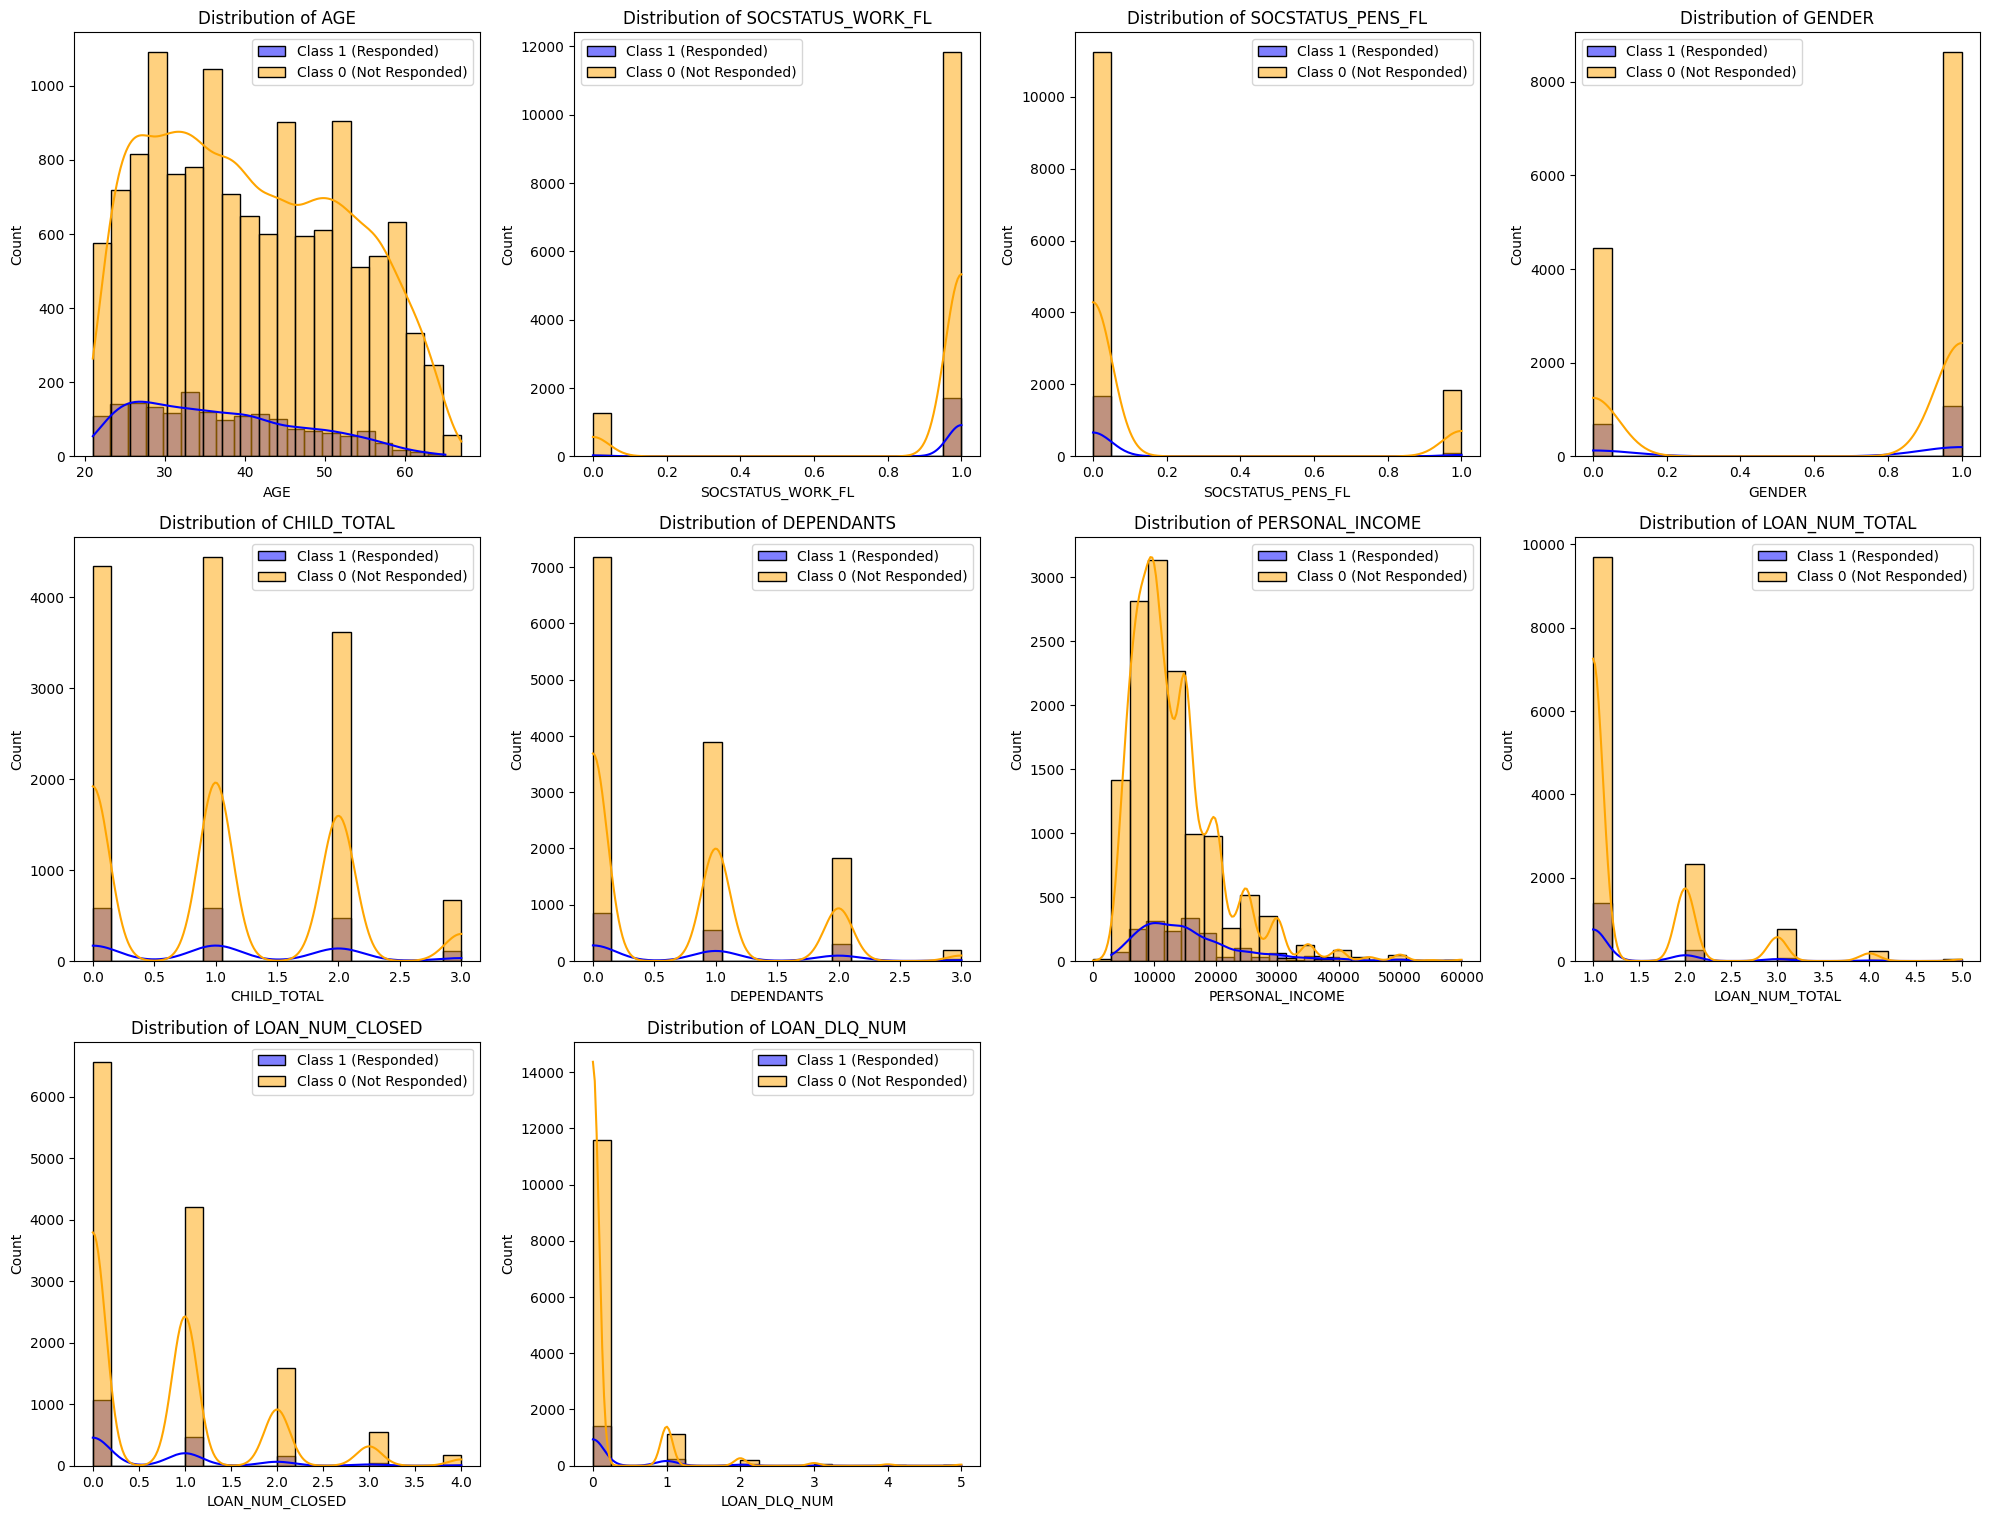

In [ ]:
# Получим список всех признаков, кроме целевой переменной
all_features = [col for col in X.columns]
def show_histograms():
    # Разделение данных на клиентов с откликом и без отклика
    data_class_1 = data[data['TARGET'] == 1]  # Класс 1 (с откликом)
    data_class_0 = data[data['TARGET'] == 0]  # Класс 0 (без отклика)
    # Анализ клиентов с откликами (TARGET = 1)
    # Посмотрим распределение всех признаков для клиентов с откликом
    plt.figure(figsize=(20, 30))
    for i, feature in enumerate(all_features, 1):
        plt.subplot(6, 4, i)# Разбиваем на 6 строк и 4 столбца для удобства отображения
        sns.histplot(data=data_class_1, x=feature, kde=True, bins=20, color='blue', label='Class 1 (Responded)')
        sns.histplot(data=data_class_0, x=feature, kde=True, bins=20, color='orange', label='Class 0 (Not Responded)', alpha=0.5)
        plt.title(f'Distribution of {feature}')
        plt.legend()
    plt.tight_layout()
    plt.show()

show_histograms()

### Анализ на основе графиков:

1. **`AGE` (Возраст)**:
   - Клиенты с откликами (класс `1`) имеют пик в возрасте от 20 до 50 лет.
   - Распределение клиентов без откликов (класс `0`) более равномерное и включает больше клиентов старше 50 лет.

2. **`SOCSTATUS_WORK_FL` (Социальный статус: работает или нет)**:
   - Клиенты с откликами в основном работают, что подчёркивает важность этого признака для модели.

3. **`SOCSTATUS_PENS_FL` (Социальный статус: пенсионер или нет)**:
   - Пенсионеры реже откликаются на предложения, и их значительно больше среди класса `0`.

4. **`GENDER` (Пол)**:
   - Распределение по полу не даёт существенных различий между классами `0` и `1`. Это подтверждает, что пол не является значимым признаком для модели.

5. **`CHILD_TOTAL` и `DEPENDANTS`**:
   - Большинство клиентов с откликами имеют 0–2 детей и 0–1 иждивенцев. Многодетные семьи встречаются крайне редко среди класса `1`.

6. **`PERSONAL_INCOME` (Личный доход)**:
   - Клиенты с доходом более 30,000 редко откликаются на предложения, в то время как большинство клиентов с откликами имеют доход в пределах 10,000–30,000.

7. **`LOAN_NUM_TOTAL` и `LOAN_NUM_CLOSED` (Общее количество ссуд и количество закрытых ссуд)**:
   - Большинство клиентов с откликами имеют 0–2 ссуды. Большее количество ссуд связано с уменьшением вероятности отклика.

8. **`LOAN_DLQ_NUM` (Количество просрочек)**:
   - Большинство клиентов с откликами не имеют просрочек (0–1). Клиенты с большим количеством просрочек практически не откликаются.

**Удалим выбросы.**

In [ ]:
data.drop(data[
    (data['LOAN_DLQ_NUM'] >5) |
    (data['PERSONAL_INCOME'] >60000) |
    (data['DEPENDANTS'] >3) |
    (data['LOAN_NUM_CLOSED'] >4) |
    (data['LOAN_NUM_TOTAL'] >5) |
    (data['CHILD_TOTAL'] >3)
].index, inplace=True)

Удаление большего количества выбросов показало немного более худшие результаты.

In [ ]:
print(len(data))

14839


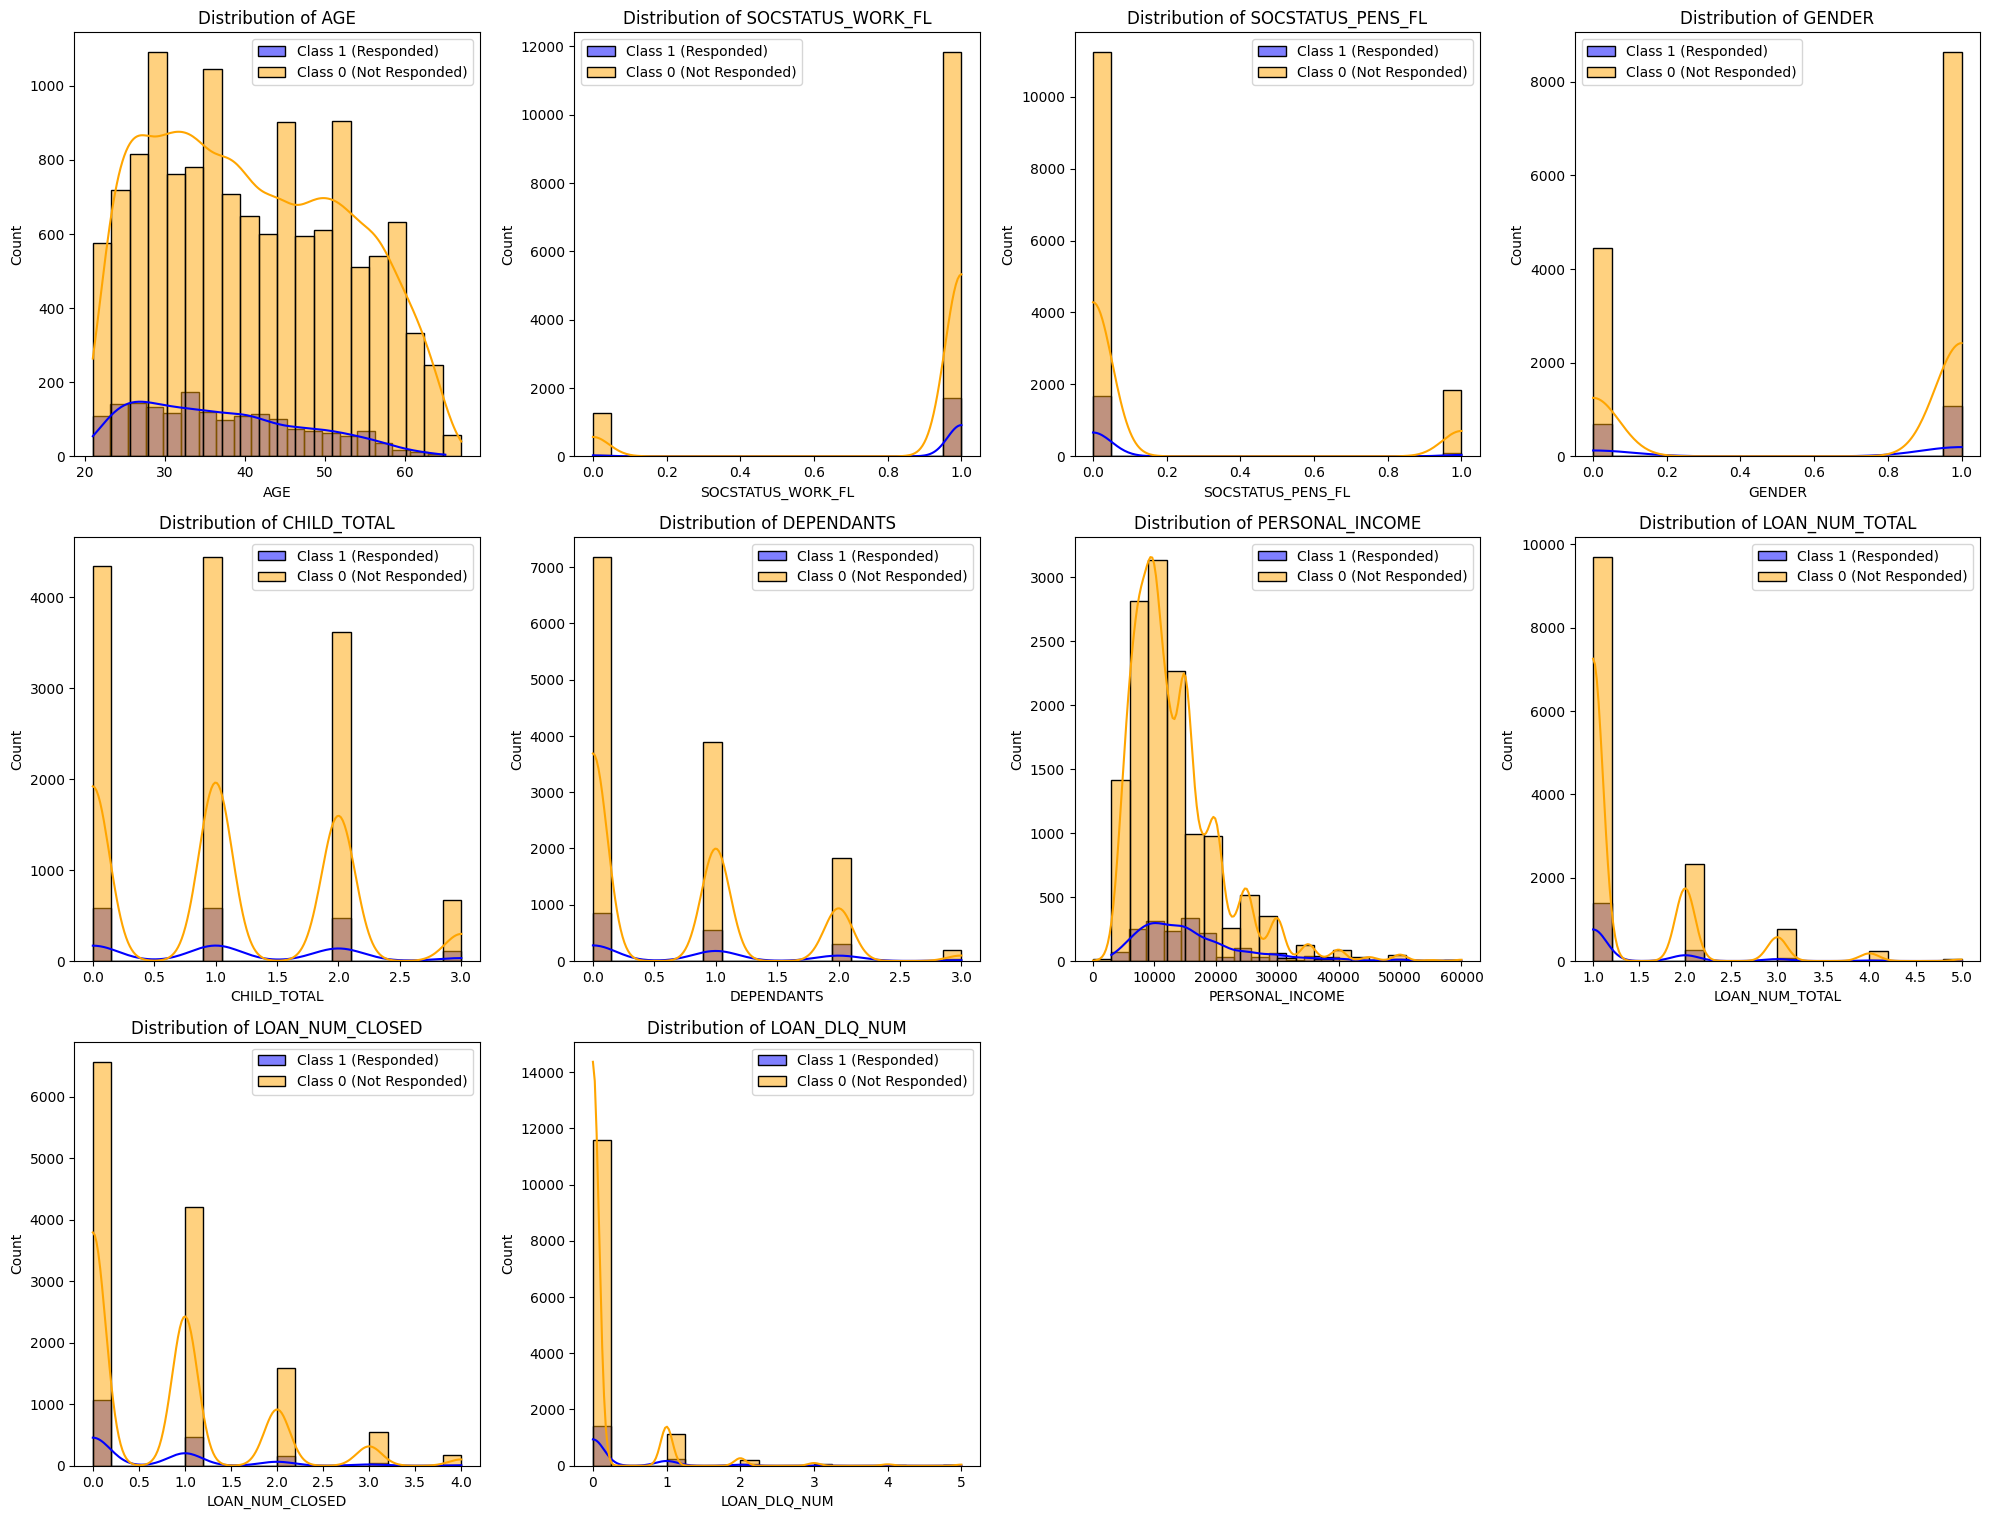

In [ ]:
show_histograms()

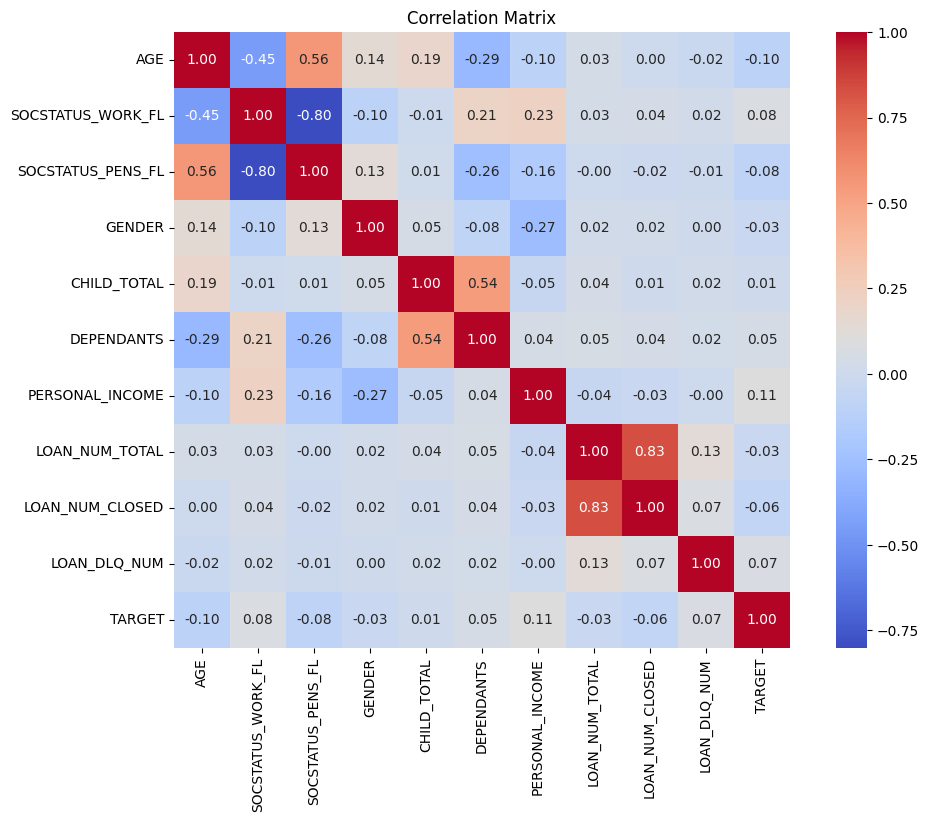

In [ ]:
# Построение матрицы корреляции
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# data = data.drop(['CHILD_TOTAL'], axis=1)
# data = data.drop(['SOCSTATUS_PENS_FL'], axis=1)
#Удаление сильно коррелирующих данных показало чуть более худшие результаты. Поэтому мы пропускаем такой шаг.

### Построение модели с учетом выбросов.